# NBA Media Analysis - Final Report

**Alexander Howard**

In [1]:
import pandas as pd
import  plotly.plotly  as py
import os
from textblob import TextBlob, Word
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

tl;dr The New York Times can predict the future!

## Contents:

1. Problem Statement & Data Acquisition
2. Data Preprocessing
3. Data Summarization and Visualisation
4. Models
5. GitHub Navigation
6. X Factor

## 1. Problem Statement

**Goal:** This project looks to understand how the media reports on the NBA season. We want to examine how both teams and individuals players are reported - both in terms of the number of mentions they receive and the associated sentiment with this mention.

The core aims of this project are to visualise this data for human exploration and to fit models that allow us to assess feature importance - which factors are most important to be represented in the media?

### Data:

All of the applicable data for this project was scraped from online sources.

**Media articles:  **
  
- ESPN: fully functioning code is available in the `/espn_scrape/` directory of this project to scrape ESPN's NBA articles. Unfortunately the ESPN server for this portion of the website is currently down, so we are unable to use these results.  
  
  
- New York Times: the text corpus of our dataset comprises every article in the NBA section of the New York Times website. The `/nyt_scrape/` directory contains all of the source code used to scrape this, including `nyt_scrape.py` which scrapes a list of article urls and `parse_article.py` which parses the raw HTML and saves the data as a .txt file. These files are also available in the `/nyt_scrape/articles/` directory.
  
  
  
  
**NBA Stats:  **
  
All scraped stats data is listed in `/player_stats/` directory.  
  
  
- BasketBall Reference: the 2017-18 schedule for each team can be scraped and processed using `! python team_results_scrape.py GSW` where 'GSW' is the appropriate team acronym. This code can actually be run by the user from the Jupyter console and the output csvs saved in the stats directory.  
  
  
- ESPN: individual player statistics were scraped using `espn_player_scrape.py` and the output is stored in `player_stats.csv`
  
  
- `team_names.csv` contains only an index of teams

Note: the scope of this project only covers the reporting of teams within the media, this repo contains the full data to do the equivalent analysis for players though (requiring identical code), we leave this as an exercise to the reader ;-)

## 2. Data Preprocessing

A large portion of the data preprocessing was accounted for by correctly acquiring the text from online sources. Once obtained, this data was invariably clean. Using textblob, we experimented with lemmatization and tagging `/Notebooks/Data EDA and Initial POS tagging prototyping.ipynb` although this was less crucial to our final models.

There were, however, two critical data processing problems that we had to solve with this data:  
1. Named Entity Recognition: detecting player/team names is crucial to our analysis, so we require to use a method that will accurately identify the correct entity. We experimented (Section 3 `/Notebooks/Data EDA and Initial POS tagging prototyping.ipynb`) with using TextBlob and SpaCy for parts of speech tagging to isolate names (such as team names) and concluded that TextBlob was more appropriate due to it's faster computation time. This analysis did show that these methods produced results very similar to matching the relevant raw string, so this would prove to be sufficient in many cases. Results of this study:

In [3]:
NER_raw_comparison = pd.read_csv('Notebooks/NER_vs_raw_strings.csv')
NER_raw_comparison

,Name,Wins,Playoffs,Conference,New York Team,City,noun_occurrences,raw_occurrences,% difference
0,Lakers,35,0,W,0,Los Angeles,103,103,0.000000
1,Cavaliers,50,4,E,0,Cleveland,370,369,-0.271003
2,Warriors,58,5,W,0,Golden State,521,525,0.761905
3,Celtics,55,3,E,0,Boston,302,297,-1.683502
4,Spurs,47,1,W,0,San Antonio,108,109,0.917431
5,76ers,52,2,E,0,Philadelphia,186,195,4.615385
6,Knicks,29,0,E,1,New York,590,591,0.169205
7,Bulls,27,0,E,0,Chicago,28,28,0.000000
8,Rockets,65,3,W,0,Houston,296,296,0.000000
9,Raptors,59,2,E,0,Toronto,153,150,-2.000000


2. Sentiment Analyser: detecting article sentiment was also very important to our project. We trialled two methods - TextBlob and Vader Sentiment and found that Vader Sentiment performed much better. Code can be found at Section 4 `/Notebooks/Data EDA and Initial POS tagging prototyping.ipynb`)

## 3. Data Summary and Visualisations

Along with the illustrative data frames that we created from our data, we created two key visualisations.

Firstly, this figure shows the number of regular season wins for each team plotted against the total number of mentions in the New York Times:

![Regular Season Wins vs Total Mentions](Notebooks/wins_mentions.png)

From this graph we clearly see one outlier with ~30 wins and 3x as many mentions as any other team - this turns out to be the New York Knicks, who are clearly reported on in much more depth due to the hometown nature of this team. The Brooklyn Nets also appear as the team who didn't reach the playoffs that have 2nd most mentions.

Secondly, the most powerful and interactive output of our whole project allows the user to define a team (by it's acronym, e.g. GSW) and run the following cells to scrape the schedule of this team and plot it against mentions in the news. This part should be fully interactive if you clone the repository and have the correct packages installed!

In [4]:
team_accronym = "PHI"
team_city = "Philadelphia"
team_name = "76ers"

Insert accronym to command line argument:

In [5]:
! python player_stats/team_results_scrape.py PHI

Complete! Output stored in PHI_results.csv and PHI_results_postseason.csv. Ready to load into memory :-)


Import some helper functions:

In [6]:
from helper_functions import load_articles, compute_sentiment, plotly_plotting

Load list of articles:

In [7]:
articles_list = pd.read_csv('nyt_scrape/articles_list_w_date.csv',parse_dates=['date'])

Load each article into memory:

In [8]:
title_date_dict, title_text_dict, file_title = load_articles(articles_list)

Compute sentiment metrics:

In [9]:
sentiment_track = compute_sentiment(title_date_dict, title_text_dict, file_title, team_name, team_city)

Read in the scraped team results:

In [10]:
results = pd.read_csv('player_stats/{}_results.csv'.format(team_accronym), parse_dates=['Date'])
# Add this line if team made postseason:
results_postseason = pd.read_csv('player_stats/{}_results_postseason.csv'.format(team_accronym), parse_dates=['Date'])

Plot with plotly:

In [11]:
fig = plotly_plotting(sentiment_track, results, results_postseason) # add 'results_postseason' as third argument only if team made playoffs
py.iplot(fig, filename='sentiment_vs_wins')

Note that GitHub doesn't support the displaying of this graph - it has to be run through your own notebook. A screengrab of the graph for Philadelphia:

![Philadelphia mentions](plotly_figure.png)

Within the full version you are able to hover over individual matches to see the opponent and scoreline!

## 4. Models

Our modelling interests lie in understanding the relationship between the number of mentions a team receives and various team statistics. For this purpose, let's use the entire corpus we have. In particular, this focus on feature importance means we are less interested in tuning hyper-parameters and metrics of model performance - emphasising much more the relative importance of features.

Below we present a shortened version of the code - full code can be found in `Notebooks/Team Frequency Analysis.ipynb`.

Read in files:

In [12]:
dir_list = os.listdir('nyt_scrape/articles')

corpus = ''

for article in dir_list:
    with open(f'nyt_scrape/articles/{article}') as f:
        corpus += f.read()
        corpus += '\n'

corpus = corpus.replace('’','').replace('”','').replace('“','').replace('—','')

corpus_blob = TextBlob(corpus)

Count Noun Entities:

Let's first define a handy function that takes the corpus and produces counter of noun tags:

In [13]:
def count_noun_tags(corpus_blob):
    tags = corpus_blob.pos_tags
    tags = [tag for tag in tags if tag[1] in {'NN','NNS','NNP','NNPS'}]
    tags = [Word(tag[0].lower()) for tag in tags]
    lemma_tags = [tag.lemmatize() for tag in tags]
    lemma_tags = [tag for tag in tags if tag not in ['s','t']]
    c = Counter(lemma_tags)
    
    return c
    

In [14]:
c = count_noun_tags(corpus_blob)

Read in data about teams:

In [15]:
team_names = pd.read_csv('player_stats/team_names.csv')
playoff_dict = {0:'DNQ',1:'First Round',2:'Second Round',3:'Conference Finals',4:'NBA Finals',5:'Champion'}  # Decoding
team_names['playoff_round'] = team_names.Playoffs.apply(lambda x : playoff_dict[x])
names = list(team_names['Name'])

Count number of matching noun occurrences:

In [16]:
team_names['noun_occurrences'] = [c[name.lower()] for name in names]
team_names.sort_values(['noun_occurrences'],ascending=False).head()

,Name,Wins,Playoffs,Conference,New York Team,City,playoff_round,noun_occurrences
6,Knicks,29,0,E,1,New York,DNQ,590
2,Warriors,58,5,W,0,Golden State,Champion,521
1,Cavaliers,50,4,E,0,Cleveland,NBA Finals,370
3,Celtics,55,3,E,0,Boston,Conference Finals,302
8,Rockets,65,3,W,0,Houston,Conference Finals,296


This data can be found in the first plot of section 3.

**Regular Season:**

For greater parity, let's restrict our data to only the regular season:

In [17]:
postseason_start = pd.to_datetime('2018-04-14')

articles_list['regular_season'] = articles_list.date < postseason_start

regular_season_corpus = ''

for index, row in articles_list.iterrows():
    if row['regular_season']:
        article = row["article_urls"].replace("/","").replace(".","")
        with open(f'nyt_scrape/articles/{article}.txt') as f:
            regular_season_corpus += f.read()
            regular_season_corpus += '\n'

In [18]:
c = count_noun_tags(TextBlob(regular_season_corpus))

In [19]:
team_names['regular_occurrences'] = [c[name.lower()] for name in names]
team_names.sort_values(['regular_occurrences'],ascending=False).head()

,Name,Wins,Playoffs,Conference,New York Team,City,playoff_round,noun_occurrences,regular_occurrences
6,Knicks,29,0,E,1,New York,DNQ,590,559
2,Warriors,58,5,W,0,Golden State,Champion,521,168
1,Cavaliers,50,4,E,0,Cleveland,NBA Finals,370,147
24,Nets,28,0,E,1,Brooklyn,DNQ,146,145
3,Celtics,55,3,E,0,Boston,Conference Finals,302,130


### Linear Model:

Now we try to fit a Linear Model to understand the most important factors in increasing the number of mentions for each team.

For this purpose, we drop the Knicks and Nets from our dataset, since they obviously corrupt the data.

In [20]:
team_names.drop([6,24],inplace=True)  # Drop Knicks, Nets

In [21]:
team_names.Conference = team_names.Conference.apply(lambda x : 0 if x=="E" else 1)  # Numeric Encoding

In [22]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

Define predicor columns:

In [23]:
predictor_cols = ['Wins','Playoffs','Conference']

Fit model:

In [24]:
model.fit(team_names[predictor_cols],team_names.regular_occurrences)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
coefs = zip(predictor_cols,model.coef_)
for coef in coefs:
    print(f"Our model predicts that for a unit increase in {coef[0]}, a team will receive **{round(coef[1],2)}** more mentions in the NYT during the regular season.\n")

Our model predicts that for a unit increase in Wins, a team will receive **-0.64** more mentions in the NYT during the regular season.

Our model predicts that for a unit increase in Playoffs, a team will receive **27.0** more mentions in the NYT during the regular season.

Our model predicts that for a unit increase in Conference, a team will receive **7.56** more mentions in the NYT during the regular season.



So this model actually shows that the number of wins a team gains does not improve the mentions it receives - this number actually decreases. All the weight of having a winning season is in reaching further rounds of the playoffs (even though our corpus doesn't include any playoff data!).

Now let's plot the linear regression model that matches only wins against number of mentions:

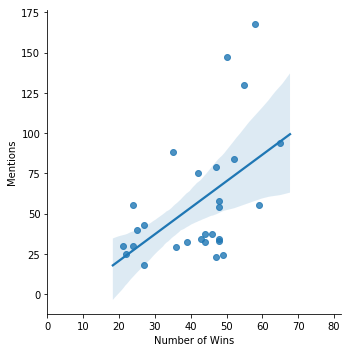

In [26]:
g = sns.lmplot(x="Wins", y="regular_occurrences", data=team_names,fit_reg = True, legend = True)
g.set_axis_labels(x_var = "Number of Wins", y_var = "Mentions")
g.axes[0,0].set_xlim(0,82)
plt.show()

### Random Forest Model:

In [27]:
from sklearn.ensemble import RandomForestRegressor
from rfpimp import *

In [28]:
RF = RandomForestRegressor()
RF.fit(team_names[predictor_cols],team_names.regular_occurrences)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

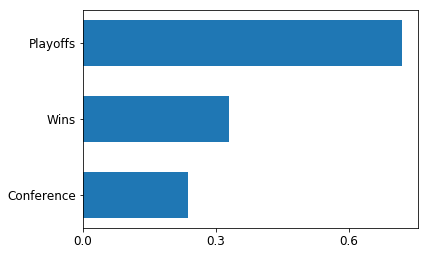

In [29]:
imp = importances(RF,team_names[predictor_cols],team_names.regular_occurrences) # permutation
plot_importances(imp)

So this method (thanks [ParrT](https://github.com/parrt/random-forest-importances)) shows the same result - Playoffs is a much stronger indicator of mentions in the media, even during the regular season.

What could this mean? Clearly the only reasonable conclusion is that the New York Times can predict the future! 

## 5. GitHub Navigation

The code is divided into key chunks, as also outlined above:
- Notebooks: Jupyter notebooks, comprising EDA and Team Analysis
- NYT_Scrape: code to scrape New York Times articles and articles data
- ESPN_Scrape: defunct code to scrape ESPN
- Player_Stats: code to scrape various player and team statistics and some raw data

## 6. X Factor

I hope to have done enough to impress the judges with my interactive charts that can be personalised to any team. The prophetic powers of the NYT also appears to be quite the bombshell.